In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Read the CSV file
df_base = pd.read_csv('/Users/bwen/personal/llm-layout/plots/test_result.csv')
df_judge = pd.read_csv('/Users/bwen/personal/llm-layout/plots/judge_result.csv')

In [10]:
# Define the LLMs and task groups
llms = [
    "GPT-4o",
    "Claude-3.5-Sonnet",
    "Llama-3.1-70B",
    "Llama-3.1-405B",
    "o1-preview"
]

groups = {
    'Basic Shapes 1': ['Circle', 'Donut', 'Oval', 'Square', 'Triangle', 'Grid'],
    'Basic Shapes 2': ['Hexagon', 'Pentagon', 'Heptagon', 'Octagon', 'Trapezoid', 'Text'],
    'Advanced Shapes': ['Arrow', 'SquareArray', 'Serpentine', 'RoundedSquare', 'BasicLayout', 'Spiral'],
    'Complex Structures': ['MicrofluidicChip', 'ViaConnection', 'FiducialCircle', 'ComplexLayout', 'DLDChip', 'FinFET', 'RectangleWithText']
}

# Define the result categories (excluding 'Error')
categories = ['Fully Correct', 'Scaling Errors', 'Partially Correct', 'Shape Errors', 'Runtime Errors']

In [11]:
# Convert the categories to integers
for category in categories:
    df_base[category] = pd.to_numeric(df_base[category], errors='coerce').fillna(0).astype(int)
    df_judge[category] = pd.to_numeric(df_judge[category], errors='coerce').fillna(0).astype(int)

In [12]:
# Function to calculate percentages for each group and LLM
def calculate_percentages(df, group, llm):
    group_df = df[df['task'].isin(group)]
    llm_data = group_df[group_df['llm'] == llm]
    total = llm_data[categories].sum().sum()
    return [llm_data[cat].sum() / total * 100 for cat in categories]

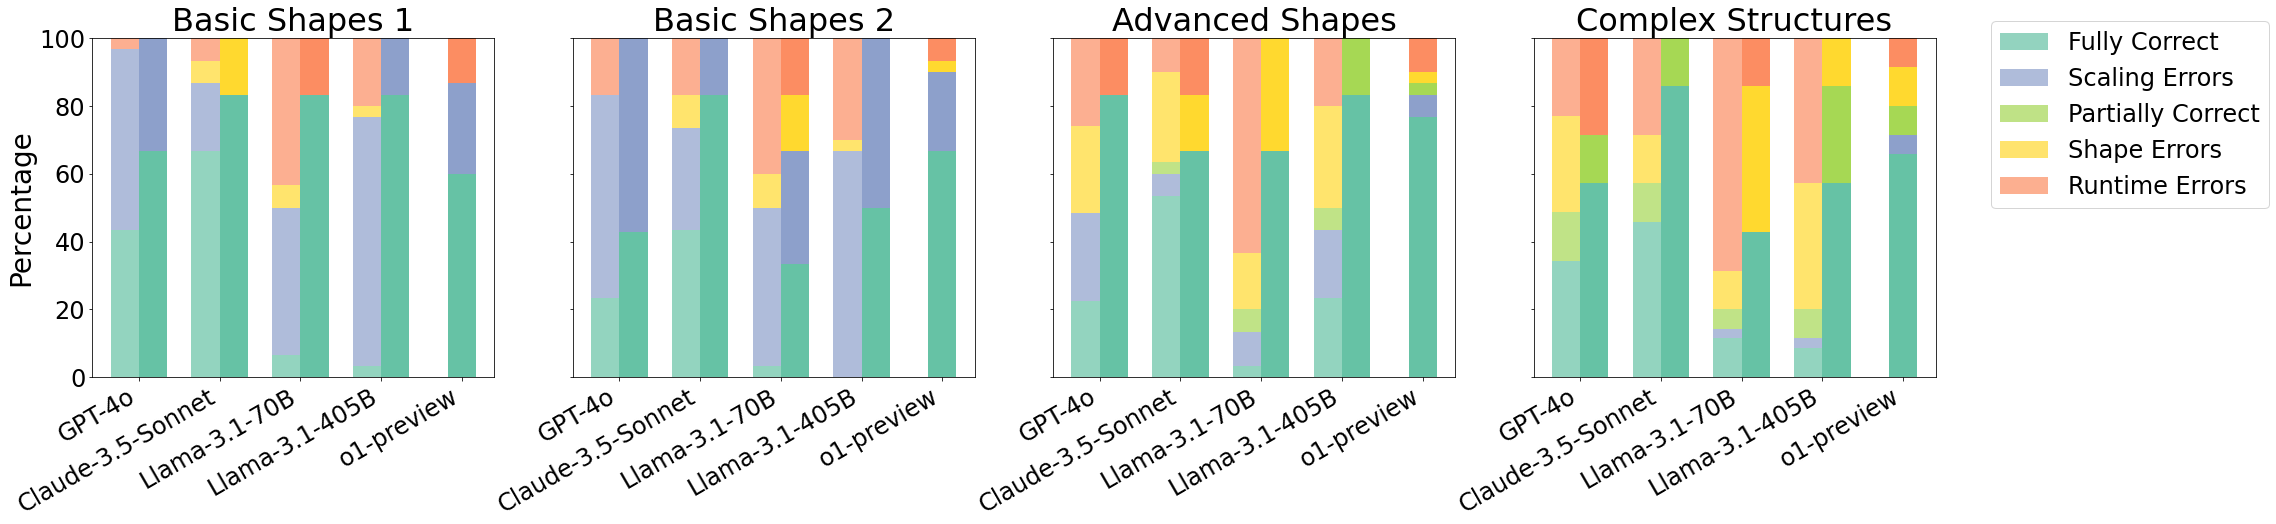

In [16]:
# Prepare data for plotting
data = {group_name: {
    **{f"{llm}_base": calculate_percentages(df_base, group, llm) for llm in llms[:-1]},
    **{f"{llm}_judge": calculate_percentages(df_judge, group, llm) for llm in llms[:-1]},
    "o1-preview": calculate_percentages(df_base, group, "o1-preview")
} for group_name, group in groups.items()}

# Set up the plot with 4 horizontal subplots sharing the y-axis
fig, axes = plt.subplots(1, 4, figsize=(32, 8), sharey=True)
# ... (previous code remains the same) ...

# Define a consistent color scheme
colors = ['#66c2a5', '#8da0cb', '#a6d854', '#ffd92f', '#fc8d62']

# Plot each group
x = np.arange(len(llms))
width = 0.35

for (group_name, group_data), ax in zip(data.items(), axes.flatten()):
    bottom_base = np.zeros(len(llms) - 1)
    bottom_judge = np.zeros(len(llms) - 1)
    bottom_o1 = np.zeros(1)
    
    for i, category in enumerate(categories):
        values_base = [group_data[f"{llm}_base"][i] for llm in llms[:-1]]
        values_judge = [group_data[f"{llm}_judge"][i] for llm in llms[:-1]]
        value_o1 = [group_data["o1-preview"][i]]
        
        ax.bar(x[:-1] - width/2, values_base, width, bottom=bottom_base, label=category if ax == axes[0] else "", color=colors[i], alpha=0.7)
        ax.bar(x[:-1] + width/2, values_judge, width, bottom=bottom_judge, color=colors[i], alpha=1)
        ax.bar(x[-1], value_o1, width, bottom=bottom_o1, color=colors[i], alpha=1)
        
        bottom_base += values_base
        bottom_judge += values_judge
        bottom_o1 += value_o1
    
    ax.set_title(group_name, fontsize=32)
    ax.set_ylabel('Percentage', fontsize=28) if ax == axes[0] else None
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(llms, rotation=30, ha='right', fontsize=24)
    ax.tick_params(axis='y', which='major', labelsize=24)

# Add a shared legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=24)

# Adjust layout to accommodate the rotated labels and legend
plt.tight_layout()
fig.subplots_adjust(top=0.85, left=0.05, right=0.85)

plt.show()